# Shadow Tomography
The following code was developed in accordance to the structure outline in the paper [Predicting Many Properties of a Quantum System from Very Few Measurements](https://arxiv.org/abs/2002.08953). In addition the [PennyLane demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows/#huang2020) on classical shadows help inform some of the choices of structure and scripts based on their examples are clear marked as such.

Necessary Libraries:

In [375]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

Generating the classical shadow. The following scripts are based on qiskit circuits.

(02/07/2024) There is something wrong with how I am generating the shadow...

In [376]:
def generate_classical_shadow(circuit, shadow_size, num_qubits):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a quantum circuit, this function creates a collection of bitstrings generated by random single-qubit Pauli measurements and records the associated random pauli measurment.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a bitstring representing the result of a random Pauli measurement on the qubits.
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bitstring in the first matrix.
    """

    # Generate the measurment scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_scheme = np.random.randint(0, 3, size = (shadow_size, num_qubits))

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros(shape = (shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    # 
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_scheme[i][j] == 0:
                qc.h(j)
            elif measurement_scheme[i][j] == 1:
                qc.h(j)
                qc.sdg(j)
            else:
                continue

        qc.measure_all()

        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([qc]).result()[0]

        # Store the bitstrings representing the measured basis states. Because the sampler is configered to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bitstring.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements.
        for j in range(num_qubits):
            measurements[i][j] = 0 if states[j] == '0' else 1

    return measurements, measurement_scheme

Reconstructing the state from the classical shadow.

In [378]:
def reconstruct_state(shadow):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a classical shadow, this function reconstructs an approximation of the density matrix of the quantum state.
    
    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.

    Returns:
        np.array: An approximation of the density matrix of the quantum state.
    """

    # Unpack the shadow.
    measurements, measurement_scheme = shadow

    # Get the shadow size.
    shadow_size = measurements.shape[0]
    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in range(shadow_size):

        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in range(num_qubits):

            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[measurement_scheme[i][j]]
            if measurements[i][j] == 0:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3 * (U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_snapshot, rho_local)

        # Average all the inverted basis states to get an approximation of the density matrix.

        rho_estimated += rho_snapshot

    return rho_estimated/shadow_size

Testing the shadow generation and state reconstruction. Using the function ``operator_distance`` we can determine how "close" the reconstructed state is to the true state.

In [379]:
def operator_distance(A, B):
    """
    Calculate the distance between two operators using the frobenius norm.

    Args:
        A (np.array): The first operator.
        B (np.array): The second operator.

    Returns:
        float: The distance between the two operators.
    """

    return np.linalg.norm((A - B), ord = 'fro')

Testing with a trivial 2 qubit state.

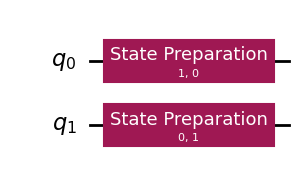

In [380]:
num_qubits = 2
trivial_2_qubit_state = [0, 0, 1, 0]

# Instantiate a quantum register with two qubits.
trivial_2_qubit_qr = QuantumRegister(num_qubits, 'q')

# Create a quantum circuit and add the prepare_state function acting on qubits 0 and 1.
trivial_2_qubit_qc = QuantumCircuit(trivial_2_qubit_qr)
trivial_2_qubit_qc.prepare_state(state = [1,0], qubits=0)
trivial_2_qubit_qc.prepare_state(state = [0,1], qubits=1)

# Draw the circuit in mpl (matplotlib).
trivial_2_qubit_qc.draw('mpl')

#Note: Qiskit is little endian so a 3 qubit tensor product is ordered as |q2> |q1> |q0>. Therefore preparing qubit 0 in state 0 and qubit 1 in state 1 give the tensor product state |10> = |1> |0>.


In [381]:
shadow = generate_classical_shadow(trivial_2_qubit_qc, 1000, 2)

rho_estimated = reconstruct_state(shadow)
print(np.round(rho_estimated, decimals = 2))

phi = np.matrix(trivial_2_qubit_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

# (25/06/2024) Note the swapped entries. Between the rho_estimated and rho_expected. The 0.97 in the rho_estimaed should be where the 1 is in the rho_expected. Fixed this by changing the order of the tensor product in the end of the reconstruct_from_shadow function (Changed this back as I think it causes other issues. It is not the root of the problem.).

# (26/06/2024) Large off-diagonal entries. Where are these coming from??? FIXED

[[-0.  +0.j   -0.02+0.02j -0.01-0.02j  0.05+0.02j]
 [-0.02-0.02j  0.97+0.j   -0.01-0.j   -0.01+0.01j]
 [-0.01+0.02j -0.01+0.j    0.  +0.j   -0.  +0.01j]
 [ 0.05-0.02j -0.01-0.01j -0.  -0.01j  0.03+0.j  ]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]]
1.392785338808533


Testing with a Bell state.

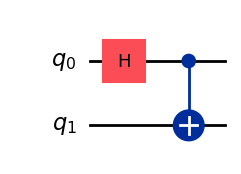

In [382]:
num_qubits = 2
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (num_qubits, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [383]:
rho = DensityMatrix.from_instruction(bell_state_qc)
print(rho)

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))


In [384]:
shadow = generate_classical_shadow(bell_state_qc, 1000, 2)

rho_estimated = reconstruct_state(shadow)
print(np.round(rho_estimated, decimals = 2))

phi = np.matrix(bell_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

# (28/06/2024) I think it is closer... The 0.5 on the anti-diagonal are there but in the wrong spot. Not sure exactly what is going on here.

[[ 0.5 +0.j   -0.01-0.06j -0.  -0.j   -0.  -0.48j]
 [-0.01+0.06j -0.01+0.j    0.47-0.02j  0.01+0.02j]
 [-0.  +0.j    0.47+0.02j -0.04+0.j    0.04+0.07j]
 [-0.  +0.48j  0.01-0.02j  0.04-0.07j  0.55+0.j  ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
1.1992153684805742


General testing. Nothing below is intended to be permenant.

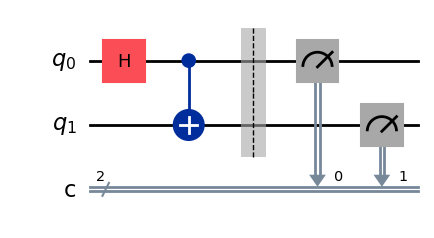

In [385]:
num_qubits = 2
test_state = [0, 0, 1, 0]

# Instantiate a quantum register with two qubits.
test_qr = QuantumRegister(num_qubits, 'q')
test_cr = ClassicalRegister(num_qubits, 'c')

# Create a quantum circuit and add the prepare_state function acting on qubits 0 and 1.
test_qc = QuantumCircuit(test_qr, test_cr)
# test_qc.prepare_state(state = [0,1], qubits=0)
# test_qc.prepare_state(state = [1,0], qubits=1)
test_qc.h(0)
test_qc.cx(0, 1)

test_qc.measure_all(add_bits=False)

# Draw the circuit in mpl (matplotlib).
test_qc.draw('mpl')

#Note: Qiskit is little endian so a 3 qubit tensor product is ordered as |q2> |q1> |q0>. Therefore preparing qubit 0 in state 0 and qubit 1 in state 1 give the tensor product state |10> = |1> |0>.


In [386]:
 # Create a sampler to simulate the quantum circuit on a single shot.
sampler = StatevectorSampler(default_shots=1)

# Run the sampler on the quantum circuit and store the result.
result = sampler.run([test_qc]).result()[0]

# Store the bitstrings representing the measured basis states. Because the sampler is configered to run the circuit once, there is only one result.
counts = result.data.c.get_counts()   

# Get the single bitstring.
states = list(list(counts.keys())[0])

print(states)

['1', '1']


Estimating Pauli Observables (using median of means estimation). In the example on the pennylane site there is a key requirment for the observables (if we want to reduce classical computation time). They must be decomposed into a sequence of tensor products of pauli operators (including the identity). I will just use the equivalent by more computationally intensive process of applying the inverse quantum channel clasically (it is just a pauli operator acting local so it is easy to do (I think...).)

In [387]:
def estimate_linear_observable(shadow, observable, k = 10):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/ and the origonal paper by Preskill.

    Given a classical shadow, an observable and value k, this function estimates the expectation value of the observable using median of means on k estimators.s

    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.
        observable (np.array): The observable to be estimated.
        k (int): The number of subsets to split the shadow into. The number of estimators. Default this is set to 10.

    Returns:
        float: The estimated expectation value of the observable.
    """

    # Size of the shadow and Number of qubits in the circuit.
    shadow_size, num_qubits = shadow.shape

    # Split the shadow into k subsets.
    shadows = np.array_split(shadow, k)

    # Array to store the estimated expectation values from each estimator.
    means = np.zeros(k)

    # Iterate over the number of estimators. Calculate the expectation value of the observable for each estimator and store the result in the means array.
    for i in shadows:
        means[i] = np.trace(observable @ reconstruct_state(i))
            
    # Return the median of the means.
    return np.median(means)



It is instructive to know how many samples are required to bound the error of our estimator by $\epsilon$ for a given set of observables. The following is an implementation of S13 in https://www.nature.com/articles/s41567-020-0932-7.

In [389]:
def matrix_inf_norm(A):
    """
    Calculate the infinity norm of a matrix.

    Args:
        A (np.array): The matrix to calculate the infinity norm of.

    Returns:
        float: The infinity norm of the matrix.
    """

    return np.max(np.sum(np.abs(A), axis = 1), axis = 0)

def shadow_bound(error, observables, failure_rate = 0.01):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    
    Given an error bound, observables and a failure rate, this function calculates the number of shadows required to achieve the error bound.

    Args:
        error (float): The maximum error in the estimation of the observables. The largest error across all observables. It is possible that many of the observables will have a smaller error.
        observables (list): The observables to be estimated represented as matrices.
        failure_rate (float): The failure rate of the error bound. The probability that the error bound is not satisfied. By defualt this is set to 0.01.

    Returns:
        float: The number of shadows required to achieve the error bound.
    
    """

    # Number of observables.
    M = len(observables) 
    # Number of estimators.
    K = 2*np.log(2*M/failure_rate)
    
    # In the case of local clifford unitaries, the shadow norm is given by the infinity norm of the observable.
    shadow_norm_square = lambda x: (matrix_inf_norm(x))**2

    # Number of samples for each estimator to achieve the error bound.
    N = (34/error**2) * max(shadow_norm_square(o) for o in observables) 

    # Return the number of shadows required (K estimators each of size N) to achieve the error bound and the number of estimators (K).
    return int(np.ceil(N*K)), int(K)
        

Compare the number of samples for error $\epsilon$ and compare it to the variance for the naive appoach of obtaining the expectation value of each observable by means of repeated projective measurements in the eigen basis of the observable (I think this is the correct wording).

~~Plotting the number of measurements for the naive approach vs the classical shadow way. We know that for a random variable the sequence of outcomes are goverend by the binomial distrobution which in the limit of infinitly long sequences gives a gaussian distrobution. For a probability distrobution we can determin the standard error give the standard deviation and number of samples. The formula is as follows $SE = \frac{\sigma}{\sqrt{n}}$ where $\sigma$ is the sample standard deviation of the distrobution and $n$ is the number of trials. For a gaussian distrobution $\sigma = ....~~ (Scratch this I do not have sample standard deviation in general...)